In [5]:
# ==============================================================
# Logistic Regression (LR) Experiment
# ==============================================================
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import prepare_data

# Experiment config
random_state = 42
results = []
partial_save_path = "results/logreg_partial_results.csv"

In [6]:
# ---
# 1. Load Data
# ---
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

print("Loaded train/test data.")

Loaded train/test data.


In [7]:
# ---
# 2. Prepare Data for LINEAR Models
# ---
# We MUST use mode="linear". This applies StandardScaler and OneHotEncoder.
# We fit ONCE on the training data.
print("Fitting encoders and scalers on train data...")
out_train_init = prepare_data(
    train_df,
    mode="linear",
    training=False,  # We only need the encoders/scalers
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"] # <-- LR needs this
print("Fit complete.")

# Prepare TEST set using the *same* "linear" mode and fitted objects
print("Preparing test set...")
out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

# Clean inf/-inf values (just in case)
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for linear models. Shape: {X_test.shape}")

Fitting encoders and scalers on train data...
Fit complete.
Preparing test set...
Test set prepared for linear models. Shape: (555719, 25)


In [8]:
# ---
# 3. Define Experiment Parameters
# ---
# We will test all ratios for this baseline model
ratios_to_test = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0] 
resample_types_to_test = ["df_up", "df_down"] 

# Logistic Regression parameters
params_to_test = [
    {
        "name": "LogisticRegression",
        "params": {
            "solver": "liblinear",
            "class_weight": None,
            "random_state": random_state
        },
    }
]

In [9]:
# ---
# 4. Run Experiment Loop
# ---
print("\nStarting Logistic Regression experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    # Prepare training data for this *specific ratio*
    # We use fit=False because we are applying the *already-fitted* scalers
    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        # Clean inf/-inf values
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()

        for p_info in params_to_test:
            model_name = p_info["name"]
            params = p_info["params"]
            start_k_time = time.time()

            print(f"    ⏳ Running {model_name} ...", end="")
            sys.stdout.flush()

            model = LogisticRegression(**params)
            
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)[:, 1]

            # Metrics
            f1 = f1_score(y_test, y_pred)
            rec = recall_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_prob)
            prec = precision_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
            
            results.append(
                {
                    "model": model_name,
                    "ratio": ratio,
                    "resample_type": resample_type.replace("df_",""),
                    "accuracy": acc,
                    "precision": prec,
                    "recall": rec,
                    "f1": f1,
                    "roc_auc": auc,
                }
            )

            print(
                f" done → F1={f1:.4f}, Recall={rec:.4f}, AUC={auc:.4f} | Time={time.time() - start_k_time:.1f}s"
            )
            sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting Logistic Regression experiment loop...

[19:28:44] Starting ratio 1/7 → ratio=None
  [19:28:49] → Training on df_up (samples=1,296,675)
    ⏳ Running LogisticRegression ... done → F1=0.1084, Recall=0.0601, AUC=0.8337 | Time=17.7s
  [19:29:09] → Training on df_down (samples=1,296,675)
    ⏳ Running LogisticRegression ... done → F1=0.1084, Recall=0.0601, AUC=0.8337 | Time=14.5s
  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=None in 0.6 min

[19:29:23] Starting ratio 2/7 → ratio=0.05
  [19:29:32] → Training on df_up (samples=1,353,627)
    ⏳ Running LogisticRegression ... done → F1=0.3765, Recall=0.3678, AUC=0.8371 | Time=13.2s
  [19:29:45] → Training on df_down (samples=157,626)
    ⏳ Running LogisticRegression ... done → F1=0.3744, Recall=0.3627, AUC=0.8361 | Time=1.7s
  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=0.05 in 0.4 min

[19:29:47] Starting ratio 3/7 → ratio=0.1
  [19:29:52] → Training

In [10]:
# ---
# 5. Show Final Results
# ---
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing Logistic Regression Models ---")
print(results_df.head(10))

results_df.to_csv("results/logreg_results.csv", index=False)
print("\nSaved final results to results/logreg_results.csv")


All ratios completed.
Total experiments logged: 14

--- Top Performing Logistic Regression Models ---
                 model  ratio resample_type  accuracy  precision    recall  \
2   LogisticRegression   0.05            up  0.995298   0.385630  0.367832   
3   LogisticRegression   0.05          down  0.995321   0.386872  0.362704   
4   LogisticRegression   0.10            up  0.993382   0.269474  0.417716   
5   LogisticRegression   0.10          down  0.993216   0.263464  0.421911   
7   LogisticRegression   0.20          down  0.987449   0.150608  0.485315   
6   LogisticRegression   0.20            up  0.987132   0.146269  0.482517   
8   LogisticRegression   0.30            up  0.980445   0.107965  0.559907   
9   LogisticRegression   0.30          down  0.980265   0.106933  0.559441   
10  LogisticRegression   0.50            up  0.958326   0.061441  0.686247   
11  LogisticRegression   0.50          down  0.958463   0.061342  0.682517   

          f1   roc_auc  
2   0.376521 


Generating plots...


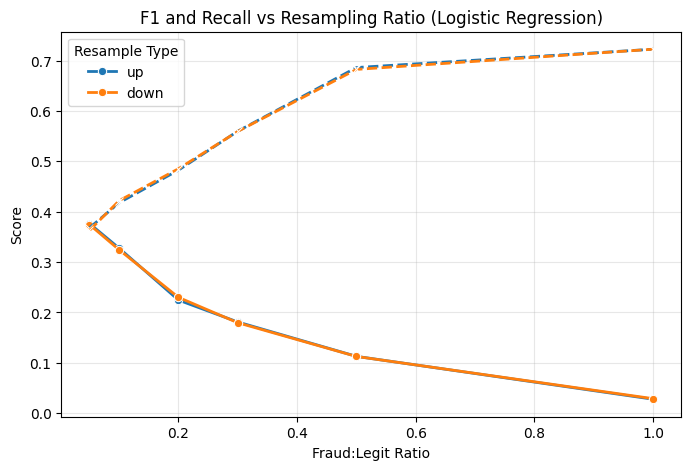

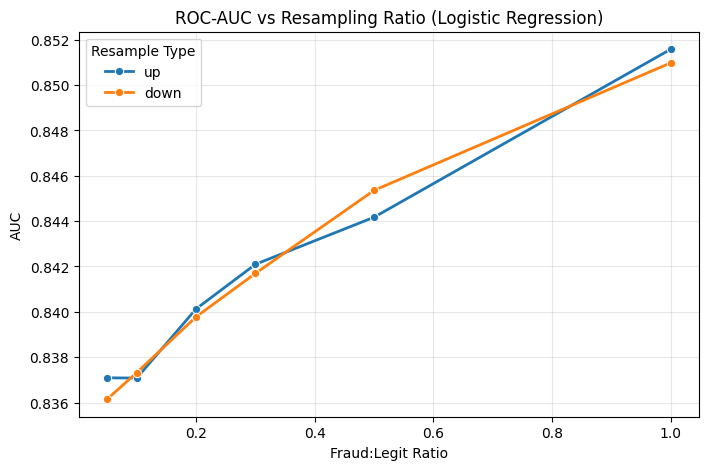

Plots saved to /results directory.


In [11]:
# ---
# 6. Plot Results
# ---

# ---- Plot F1 & Recall vs Ratio ----
print("\nGenerating plots...")
plt.figure(figsize=(8,5))

# Plot F1
sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type",
             marker="o", linewidth=2, legend="brief")

# Plot Recall on same chart
sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type",
             marker="x", linestyle="--", linewidth=2, legend=False)

plt.title("F1 and Recall vs Resampling Ratio (Logistic Regression)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.savefig("results/logreg_f1_recall_plot.png")
plt.show()

# ---- Plot ROC-AUC vs Ratio ----
plt.figure(figsize=(8,5))
sns.lineplot(data=results_df, x="ratio", y="roc_auc", hue="resample_type",
             marker="o", linewidth=2)
plt.title("ROC-AUC vs Resampling Ratio (Logistic Regression)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("AUC")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.savefig("results/logreg_auc_plot.png")
plt.show()

print("Plots saved to /results directory.")